In [1]:
%matplotlib inline
import torch.nn as nn

In [4]:
path=Path('data/mnist1')

In [5]:
path.ls()

[PosixPath('data/mnist1/mnist.pkl.gz')]

In [6]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

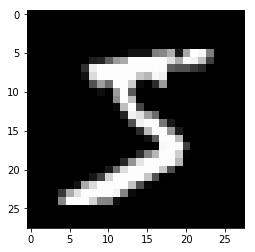

In [7]:
plt.imshow(x_train[0].reshape((28,28)),cmap='gray')
x_train.shape

In [8]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [9]:
batch_size=64
train_ds=TensorDataset(x_train,y_train)
valid_ds=TensorDataset(x_valid,y_valid)

In [10]:
data=DataBunch.create(train_ds,valid_ds,batch_size)

In [2]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin=nn.Linear(784,10,bias=True)
        
    def forward(self,xb):
        return self.lin(xb)

In [3]:
model=Mnist_Logistic().cuda()

In [13]:
x,y = next(iter(data.train_dl))


In [14]:
model(x).shape

torch.Size([64, 10])

In [15]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0206,  0.0090,  0.0224,  ..., -0.0155,  0.0351, -0.0313],
        [ 0.0216, -0.0077,  0.0173,  ...,  0.0271, -0.0095, -0.0332],
        [ 0.0178, -0.0241, -0.0200,  ...,  0.0310,  0.0345, -0.0169],
        ...,
        [-0.0328,  0.0209,  0.0355,  ...,  0.0089,  0.0274, -0.0343],
        [-0.0131,  0.0325, -0.0343,  ..., -0.0063,  0.0180,  0.0285],
        [-0.0169, -0.0176,  0.0231,  ...,  0.0333, -0.0190, -0.0020]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0221,  0.0350, -0.0193,  0.0187,  0.0125, -0.0112,  0.0112, -0.0198,
         0.0094,  0.0228], device='cuda:0', requires_grad=True)


The two matrices are the multiplication matrix and the bias matrix

In [16]:
lr=2e-2

In [17]:
loss_func=nn.CrossEntropyLoss()

In [21]:
def update(x,y,lr):
    wd=1e-5
    y_pred=model(x)
    w2=0
    for p in model.parameters(): w2+=(p**2).sum()
    loss=loss_func(y_pred,y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()        
        

In [22]:
loss=[update(x,y,lr) for x,y in data.train_dl]

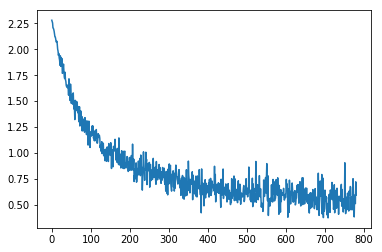

In [25]:
plt.plot(loss)

In [39]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1=nn.Linear(784,100,bias=True)
        self.lin2=nn.Linear(100,10,bias=True)
    def forward(self,xb):
        xb=self.lin1(xb)
        xb=F.relu(xb)
        return self.lin2(xb)
        

In [40]:
def update(x,y,lr):
    opt=optim.Adam(model.parameters(),lr,weight_decay=1e-5)
    y_hat=model(x)
    loss=loss_func(y_hat,y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()
    
    

In [41]:
model=Mnist_NN().cuda()

In [42]:
loss_list=[update(x,y,lr=1e-3) for x,y in data.train_dl]

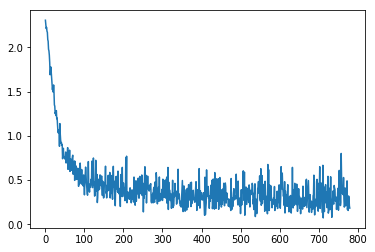

In [43]:
plt.plot(loss_list)

In [65]:
learn=Learner(data,Mnist_NN(),loss_func=loss_func,metrics=accuracy)

In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


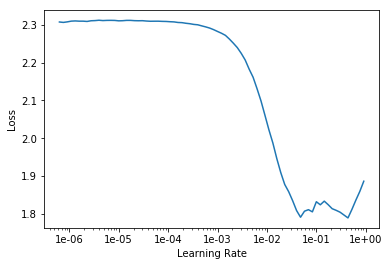

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.118353,0.107428,0.967300,00:05


Now we will look at what fit one cycle does exactly

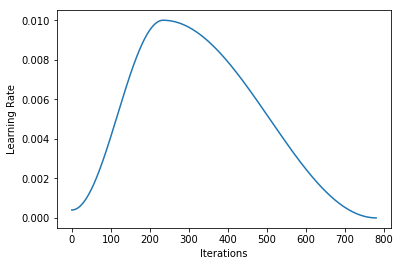

In [54]:
learn.recorder.plot_lr()

Fit one cycle varies the learning rate and fit keeps lr constant as can be seen below


In [68]:
learn=Learner(data,Mnist_NN(),loss_func=loss_func,metrics=accuracy)

In [69]:
learn.fit(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.161045,0.159804,0.952800,00:04


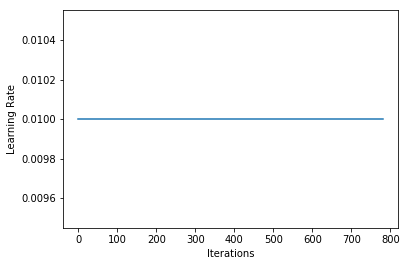

In [75]:
learn.recorder.plot_lr()